In [1]:
from model import Unet, UnetWithSA
from dataset import LiTS
import torch
from torch.optim import Adam
from utils import *
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from argparse import ArgumentParser
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import os
import shutil

In [13]:
model = Unet()

In [14]:
checkpoint = torch.load(r'D:\DLFS\Unet\model1w\last_cnn.pt', map_location=torch.device('cpu'))
start_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])

<All keys matched successfully>

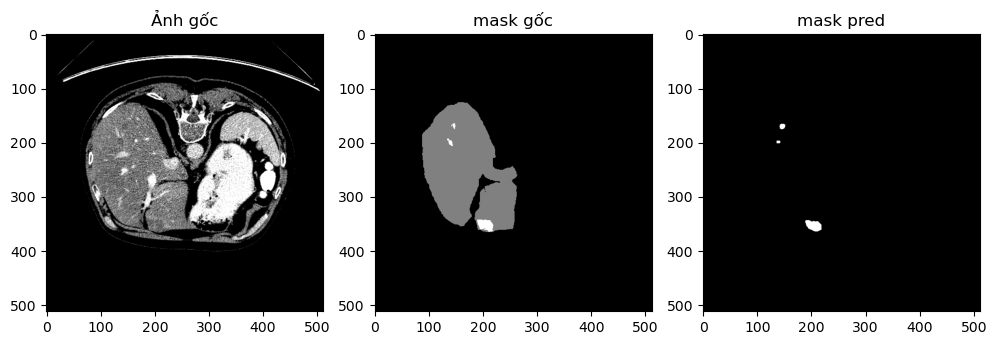

In [15]:
import SimpleITK as sitk
import numpy as np
import torch
import torch.nn.functional as F

model.eval()

image_path = r'D:\DLFS\Unet\sample\test\image\volume-842.nii'
target_path = r'D:\DLFS\Unet\sample\test\target\segmentation-842.nii'

image = sitk.ReadImage(image_path)

clamp_filter = sitk.ClampImageFilter()
clamp_filter.SetLowerBound(-45)
clamp_filter.SetUpperBound(167)
clamped_image = clamp_filter.Execute(image)
clamped_image = sitk.GetArrayFromImage(clamped_image)

clamped_image = torch.from_numpy(clamped_image).unsqueeze(0).float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clamped_image = clamped_image.to(device)
model = model.to(device)


with torch.no_grad():
    pred = model(clamped_image)
    pred = (pred > 0.5).float().cpu().numpy().squeeze(0)

import matplotlib.pyplot as plt
image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(target_path)

clamp_filter = sitk.ClampImageFilter()
clamp_filter.SetLowerBound(-45)  
clamp_filter.SetUpperBound(167)

clamped_image = clamp_filter.Execute(image)

origin_array = sitk.GetArrayFromImage(image)
image_array = sitk.GetArrayFromImage(clamped_image)
mask_array = sitk.GetArrayFromImage(mask)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_array[0], cmap='gray')
plt.title("Ảnh gốc")
plt.axis("on")

plt.subplot(1, 3, 2)
plt.imshow(mask_array[0], cmap='gray')
plt.title("mask gốc")
plt.axis("on")

plt.subplot(1, 3, 3)
plt.imshow(pred[0], cmap='gray')
plt.title("mask pred")

plt.tight_layout()
plt.show()